<p><img alt="Colaboratory logo" height="45px" src="https://www.quantreo.com/wp-content/uploads/2021/10/Original-on-Transparent.png" align="left" hspace="10px" vspace="0px"></p>

# Advanced crypto strategies

### Summary
* Manage the data
* Features engineering
* Split the data
* Standardization
* Principal component analysis
* Machine Learning modelling
* Compute the profit
* Automatization

<br>


💰Join our community: https://discord.gg/wXjNPAc5BH

📚Read our book: https://www.amazon.com/gp/product/B09HG18CYL 

🖥️Quantreo's YouTube channel: https://www.youtube.com/channel/UCp7jckfiEglNf_Gj62VR0pw

In [ ]:
!pip install ta

In [ ]:
!pip install yfinance

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# The code here will allow you to switch your graphics to dark mode for those who choose to code in dark mode
import matplotlib.pyplot as plt

import matplotlib as mpl
from matplotlib import cycler
colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")

In [ ]:
def BackTest(serie, annualiazed_scalar=252):
  def drawdown_function(serie):

    # We compute Cumsum of the returns
    cum = serie.dropna().cumsum() + 1

    # We compute max of the cumsum on the period (accumulate max) # (1,3,5,3,1) --> (1,3,5,5,5)
    running_max = np.maximum.accumulate(cum)

    # We compute drawdown
    drawdown = cum/running_max - 1
    return drawdown

  # Import the benchmark
  sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
  
  # Change the name
  sp500.name = "SP500"

  # Concat the returns and the sp500
  val = pd.concat((serie,sp500), axis=1).dropna()
  # Compute the drawdown
  drawdown = drawdown_function(serie)*100
  
  # Compute max drawdown
  max_drawdown = -np.min(drawdown)




  # Put a subplots
  fig, (cum, dra) = plt.subplots(1,2, figsize=(20,6))
  
  # Put a Suptitle
  fig.suptitle("Backtesting", size=20)

  # Returns cumsum chart
  cum.plot(serie.cumsum()*100, color="#39B3C7")

  # SP500 cumsum chart
  cum.plot(val["SP500"].cumsum()*100, color="#B85A0F")

  # Put a legend
  cum.legend(["Portfolio", "SP500"])
  
  # Set individual title
  cum.set_title("Cumulative Return", size=13)

  cum.set_ylabel("Cumulative Return %", size=11)

  # Put the drawdown
  dra.fill_between(drawdown.index,0,drawdown, color="#C73954", alpha=0.65)

  # Set individual title
  dra.set_title("Drawdown", size=13)

  dra.set_ylabel("drawdown in %", size=11)

  # Plot the graph
  plt.show()


  # Compute the sortino
  sortino = np.sqrt(annualiazed_scalar) * serie.mean()/serie.loc[serie<0].std()

  # Compute the beta
  beta = np.cov(val[["return", "SP500"]].values,rowvar=False)[0][1] / np.var(val["SP500"].values)

  # Compute the alpha
  alpha = annualiazed_scalar * (serie.mean() - beta*serie.mean())

  # Print the statistics
  print(f"Sortino: {np.round(sortino,3)}")
  print(f"Beta: {np.round(beta,3)}")
  print(f"Alpha: {np.round(alpha*100,3)} %")
  print(f"MaxDrawdown: {np.round(max_drawdown,3)} %")

# Manage the data

In [ ]:
def prepocessing(name):
  # Import the data
  df = pd.read_csv(name, delimiter="\t", parse_dates=True, index_col="<DATE>")
  
  # Delete the second last columns
  df = df.iloc[:,:-2]

  # Rename
  df.columns = ["open", "high", "low", "close", "volume"]
  df.index.name = "date"

  return df
  
df = prepocessing("LTCUSD_D1.csv")
df

,open,high,low,close,volume
date,,,,,
2013-01-12,0.070,0.070,0.070,0.070,356
2013-01-13,0.070,0.070,0.070,0.070,321
2013-01-14,0.060,0.060,0.050,0.060,1148
2013-01-15,0.060,0.060,0.060,0.060,253
2013-01-16,0.060,0.060,0.060,0.060,301
...,...,...,...,...,...
2022-01-05,147.563,149.882,135.766,136.065,22540
2022-01-06,136.065,137.965,129.767,136.365,25750
2022-01-07,136.365,136.965,125.937,132.393,29927


# Feature engineering

In [ ]:
def feature_engineering(df, lag=10):
    """ Create new variables"""
    
    # We copy the dataframe to avoid interferences in the data
    df_copy = df.dropna().copy()
    
    # Create the returns
    df_copy["return"] = df_copy["close"].pct_change(1)
    df_copy["return_lag"] = df_copy["close"].pct_change(lag)


    # Create the volatilities
    df_copy["MSD 10"] = df_copy[["return"]].rolling(10).std().shift(lag)
    df_copy["MSD 30"] = df_copy[["return"]].rolling(30).std().shift(lag)

    
    # Create the Ichimoku
    IC = ta.trend.IchimokuIndicator(df_copy["high"], df_copy["low"])
    df_copy["ichimoku_a"] = IC.ichimoku_a().shift(lag)
    df_copy["ichimoku_b"] = IC.ichimoku_b().shift(lag)
    df_copy["ichimoku_base"] = IC.ichimoku_base_line().shift(lag)
    df_copy["ichimoku_conversion"] = IC.ichimoku_conversion_line().shift(lag)

    
    return df_copy.dropna()

In [ ]:
# Import TA library
import ta

# Create the features
dfc = feature_engineering(df, lag=1)

dfc

,open,high,low,close,volume,return,return_lag,MSD 10,MSD 30,ichimoku_a,ichimoku_b,ichimoku_base,ichimoku_conversion
date,,,,,,,,,,,,,
2013-02-12,0.080,0.080,0.070,0.070,893,-0.125000,-0.125000,0.045175,0.048305,0.07000,0.0650,0.0650,0.0750
2013-02-13,0.070,0.080,0.070,0.070,604,0.000000,0.000000,0.063247,0.053871,0.07000,0.0650,0.0650,0.0750
2013-02-14,0.070,0.070,0.070,0.070,581,0.000000,0.000000,0.063247,0.046489,0.07000,0.0650,0.0650,0.0750
2013-02-15,0.070,0.070,0.070,0.070,986,0.000000,0.000000,0.063247,0.046489,0.07000,0.0650,0.0650,0.0750
2013-02-16,0.080,0.080,0.080,0.080,847,0.142857,0.142857,0.063247,0.046489,0.07000,0.0650,0.0650,0.0750
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-05,147.563,149.882,135.766,136.065,22540,-0.077919,-0.077919,0.031718,0.048099,167.60275,218.2450,180.5445,154.6610
2022-01-06,136.065,137.965,129.767,136.365,25750,0.002205,0.002205,0.038694,0.049615,163.99125,215.5460,176.7705,151.2120
2022-01-07,136.365,136.965,125.937,132.393,29927,-0.029128,-0.029128,0.034358,0.048201,157.73250,212.5465,169.9970,145.4680


In [ ]:
dfc.iloc[:,7:]

,MSD 10,MSD 30,ichimoku_a,ichimoku_b,ichimoku_base,ichimoku_conversion
date,,,,,,
2013-02-12,0.045175,0.048305,0.07000,0.0650,0.0650,0.0750
2013-02-13,0.063247,0.053871,0.07000,0.0650,0.0650,0.0750
2013-02-14,0.063247,0.046489,0.07000,0.0650,0.0650,0.0750
2013-02-15,0.063247,0.046489,0.07000,0.0650,0.0650,0.0750
2013-02-16,0.063247,0.046489,0.07000,0.0650,0.0650,0.0750
...,...,...,...,...,...,...
2022-01-05,0.031718,0.048099,167.60275,218.2450,180.5445,154.6610
2022-01-06,0.038694,0.049615,163.99125,215.5460,176.7705,151.2120
2022-01-07,0.034358,0.048201,157.73250,212.5465,169.9970,145.4680


In [ ]:
# Compute the value which have 66% of the ordered values before (percentile 67)
np.quantile(dfc["return_lag"].dropna(),0.67)

0.011764705882353121

In [ ]:
# Create dummy variable:
# 0 --> the variation is lower than percentile 67
# 1 --> the variation is higher than percentile 67
dfc["dummy"] = 0
percentile = np.quantile(dfc["return_lag"].dropna(),0.67)
dfc.loc[dfc["return_lag"]>percentile, "dummy"] = 1

In [ ]:
dfc

,open,high,low,close,volume,return,return_lag,MSD 10,MSD 30,ichimoku_a,ichimoku_b,ichimoku_base,ichimoku_conversion,dummy
date,,,,,,,,,,,,,,
2013-02-12,0.080,0.080,0.070,0.070,893,-0.125000,-0.125000,0.045175,0.048305,0.07000,0.0650,0.0650,0.0750,0
2013-02-13,0.070,0.080,0.070,0.070,604,0.000000,0.000000,0.063247,0.053871,0.07000,0.0650,0.0650,0.0750,0
2013-02-14,0.070,0.070,0.070,0.070,581,0.000000,0.000000,0.063247,0.046489,0.07000,0.0650,0.0650,0.0750,0
2013-02-15,0.070,0.070,0.070,0.070,986,0.000000,0.000000,0.063247,0.046489,0.07000,0.0650,0.0650,0.0750,0
2013-02-16,0.080,0.080,0.080,0.080,847,0.142857,0.142857,0.063247,0.046489,0.07000,0.0650,0.0650,0.0750,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-05,147.563,149.882,135.766,136.065,22540,-0.077919,-0.077919,0.031718,0.048099,167.60275,218.2450,180.5445,154.6610,0
2022-01-06,136.065,137.965,129.767,136.365,25750,0.002205,0.002205,0.038694,0.049615,163.99125,215.5460,176.7705,151.2120,0
2022-01-07,136.365,136.965,125.937,132.393,29927,-0.029128,-0.029128,0.034358,0.048201,157.73250,212.5465,169.9970,145.4680,0


# Split the data

In [ ]:
# Percentage train set
split = int(0.90 * len(dfc))

# Train set creation
X_train = dfc.iloc[:split, 7:-1]
y_train = dfc[["dummy"]].iloc[:split]


# Test set creation
X_test = dfc.iloc[split:, 7:-1]
y_test = dfc[["dummy"]].iloc[split:]

# Standardization

In [ ]:
# STANDARDISATION
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

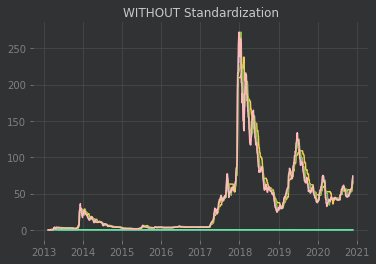

In [ ]:
plt.plot(X_train)
plt.title("WITHOUT Standardization")
plt.show()

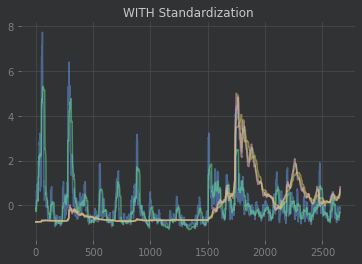

In [ ]:
plt.plot(X_train_sc, alpha=0.5)
plt.title("WITH Standardization")
plt.show()

# Principal component analysis

In [ ]:
# DIMENSION REDUCTION
from sklearn.decomposition import PCA

pca = PCA(n_components=5)

X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)

# Machine Learning modelling

In [ ]:
# Import the class
from sklearn.ensemble import RandomForestClassifier

# Initialize the class
cla = RandomForestClassifier(max_depth=3, n_estimators=100)

# Fit the model
np.random.seed(56)
cla.fit(X_train_pca, y_train)

RandomForestClassifier(max_depth=3)

# Prediction

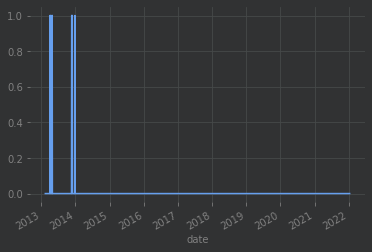

In [ ]:
# Create predictions for the whole dataset
X = np.concatenate((X_train_pca, X_test_pca), axis=0)

dfc["prediction"] = cla.predict(X)

# We verify that the algorithm doesn't predict only way (positive or negative)
dfc["prediction"].plot()

# Compute the profit

[*********************100%***********************]  1 of 1 completed


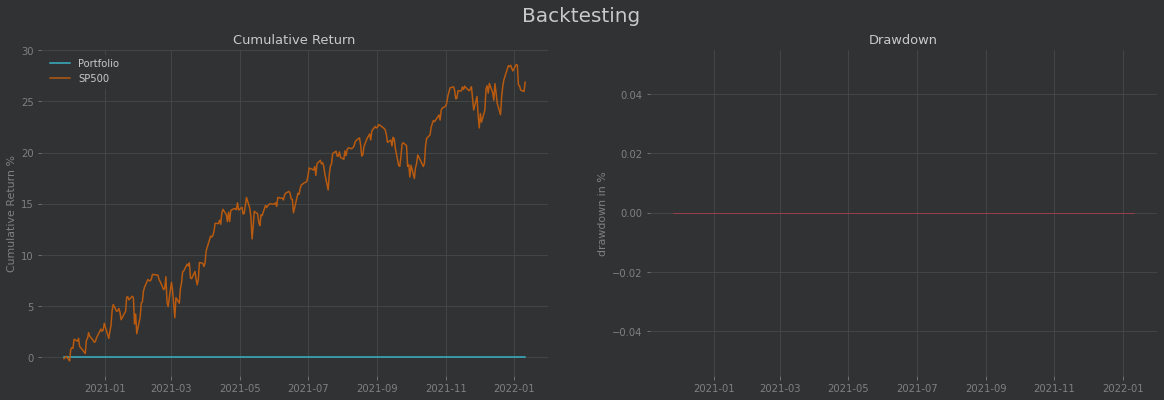

Sortino: nan
Beta: 0.0
Alpha: 0.0 %
MaxDrawdown: -0.0 %


In [ ]:
import yfinance as yf
# Compute the position
dfc["position"] = dfc["prediction"]

# Compute the returns
#dfc["strategy"] = np.array([dfc["return"].shift(i) for i in range(1)]).sum(axis=0) * (dfc["position"].shift(1))
dfc["strategy"] = dfc["return"] * dfc["position"].shift(1)

dfc["return"] = dfc["strategy"]
BackTest(dfc["return"].iloc[split:])

# Automatization

In [ ]:
def RandomForest(name,lag=10):

  def feature_engineering(df, lag=10):
    """ Create new variables"""
    lag = 10
    
    # We copy the dataframe to avoid interferences in the data
    df_copy = df.dropna().copy()
    
    # Create the returns
    df_copy["returns"] = df_copy["close"].pct_change(1)
    df_copy["returns_lag"] = df_copy["close"].pct_change(lag)
    # Create the volatilities
    df_copy["MSD 10"] = df_copy[["returns"]].rolling(10).std().shift(lag)
    df_copy["MSD 30"] = df_copy[["returns"]].rolling(30).std().shift(lag)
    
    # Create the Ichimoku
    IC = ta.trend.IchimokuIndicator(df_copy["high"], df_copy["low"])
    df_copy["ichimoku_a"] = IC.ichimoku_a().shift(lag)
    df_copy["ichimoku_b"] = IC.ichimoku_b().shift(lag)
    df_copy["ichimoku_base"] = IC.ichimoku_base_line().shift(lag)
    df_copy["ichimoku_conversion"] = IC.ichimoku_conversion_line().shift(lag)
    
    return df_copy.dropna()

  def prepocessing(name):
    df = pd.read_csv(name, delimiter="\t", parse_dates=True, index_col="<DATE>")
    df = df.iloc[:,:-2]
    df.columns = ["open", "high", "low", "close", "volume"]
    df.index.name = "date"

    return df
  
  df = prepocessing(name)
  import ta
  dfc = feature_engineering(df, lag)
  

  dfc["dummy"] = 0
  dfc.loc[dfc["returns_lag"]>np.quantile(dfc["returns_lag"],0.67),"dummy"]=1

  # Percentage train set
  split = int(0.90*len(dfc))

  # Train set creation
  X_train = dfc.iloc[:split,7:-1]
  y_train = dfc[["dummy"]].iloc[:split]


  # Test set creation
  X_test = dfc.iloc[split:,7:-1]
  y_test = dfc[["dummy"]].iloc[split:]

  # STANDARDISATION
  from sklearn.preprocessing import StandardScaler

  sc = StandardScaler()

  X_train_sc = sc.fit_transform(X_train)
  X_test_sc = sc.transform(X_test)

  # DIMENSION REDUCTION
  from sklearn.decomposition import PCA
  pca = PCA(n_components=5)

  X_train_pca = pca.fit_transform(X_train_sc)
  X_test_pca = pca.transform(X_test_sc)

  # Import the class
  from sklearn.ensemble import RandomForestClassifier

  # Initialize the class
  reg = RandomForestClassifier(max_depth=3, n_estimators=100)

  # Fit the model
  np.random.seed(56)
  reg.fit(X_train_pca, y_train)

  # Create predictions for the whole dataset
  X = np.concatenate((X_train_pca, X_test_pca), axis=0)

  #dfc["proba"] = reg.predict_proba(X)[:,0:1].reshape(-1,1)
  dfc["prediction"] = reg.predict(X)

  import yfinance as yf
  # Compute the position
  dfc["position"] = dfc["prediction"]

  # Compute the returns
  dfc["strategy"] = np.array([dfc["returns"].shift(i) for i in range(lag)]).sum(axis=0) * (dfc["position"].shift(lag))
  #dfc["strategy"] = dfc["returns"] * dfc["position"].shift(lag)

  dfc["return"] = dfc["strategy"].dropna()
  return dfc["return"].iloc[split:]/lag

[*********************100%***********************]  1 of 1 completed


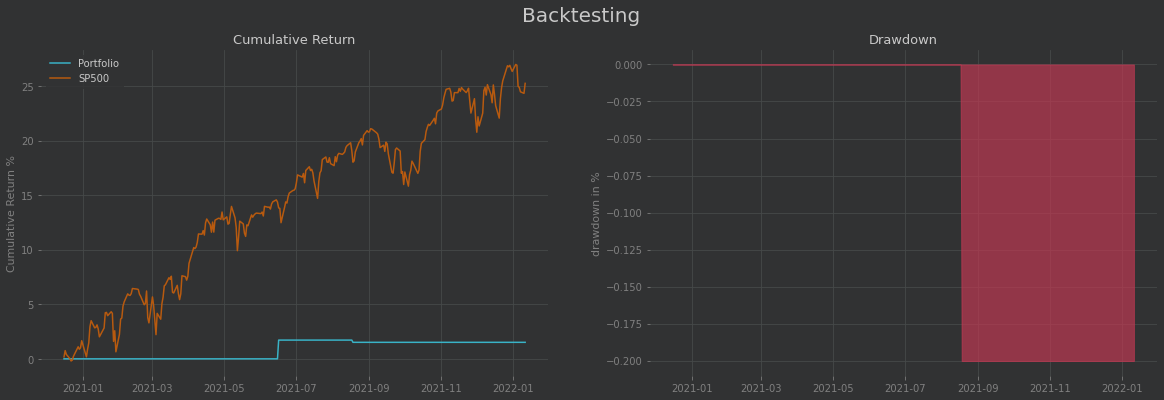

Sortino: nan
Beta: -0.005
Alpha: 0.282 %
MaxDrawdown: 0.2 %
[*********************100%***********************]  1 of 1 completed


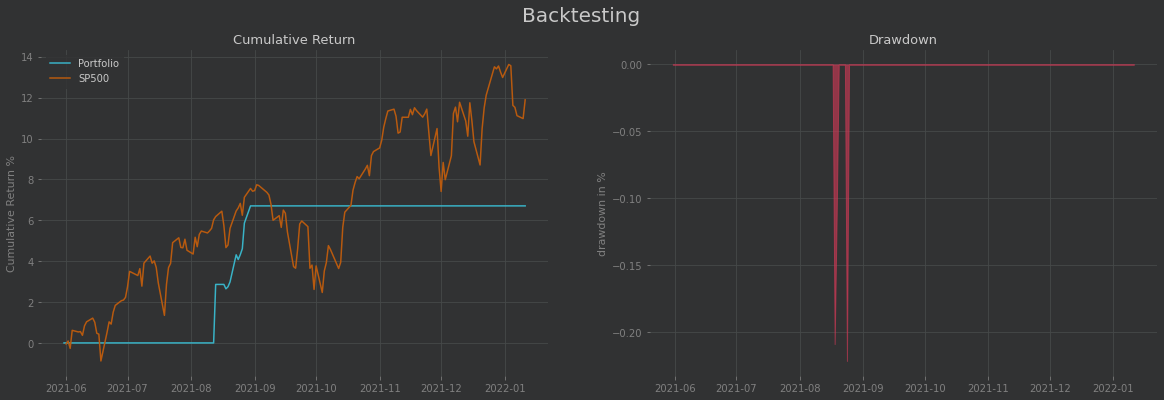

Sortino: 26.066
Beta: 0.031
Alpha: 2.085 %
MaxDrawdown: 0.222 %
[*********************100%***********************]  1 of 1 completed


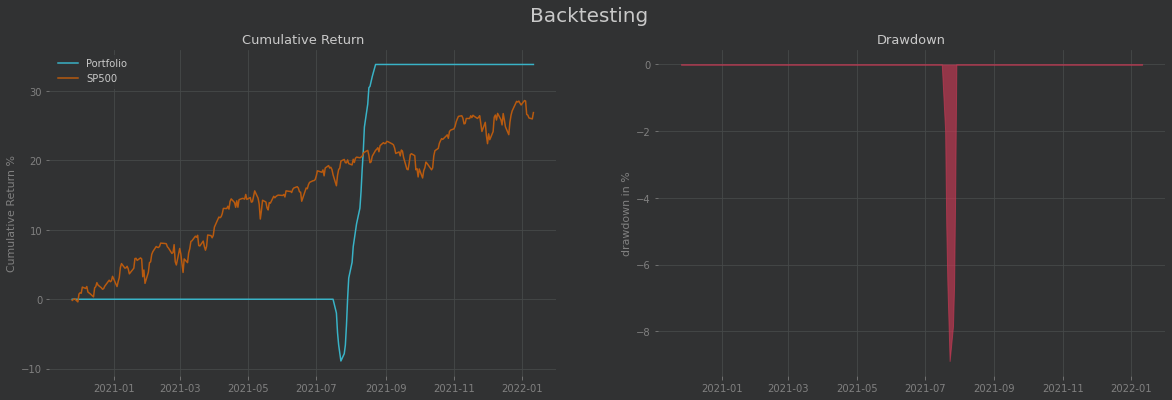

Sortino: 1.188
Beta: -0.014
Alpha: 6.047 %
MaxDrawdown: 8.892 %
[*********************100%***********************]  1 of 1 completed


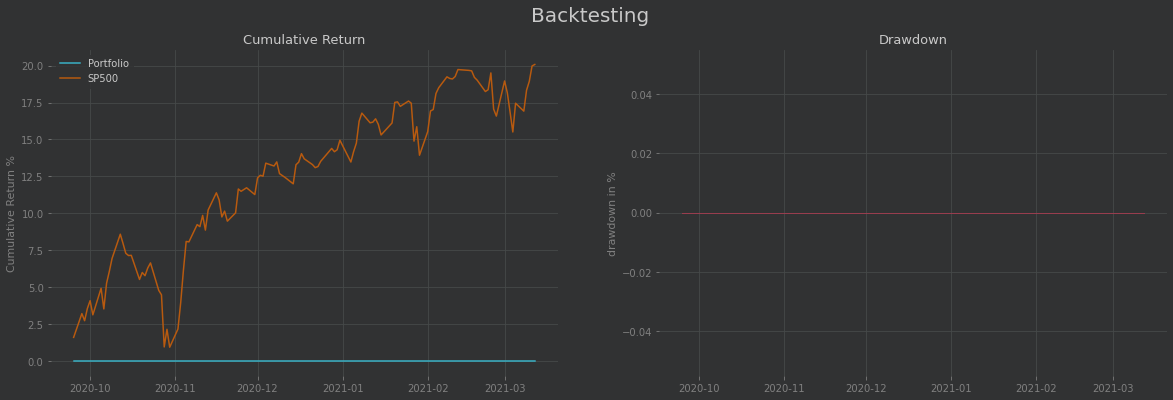

Sortino: nan
Beta: 0.0
Alpha: 0.0 %
MaxDrawdown: -0.0 %
[*********************100%***********************]  1 of 1 completed


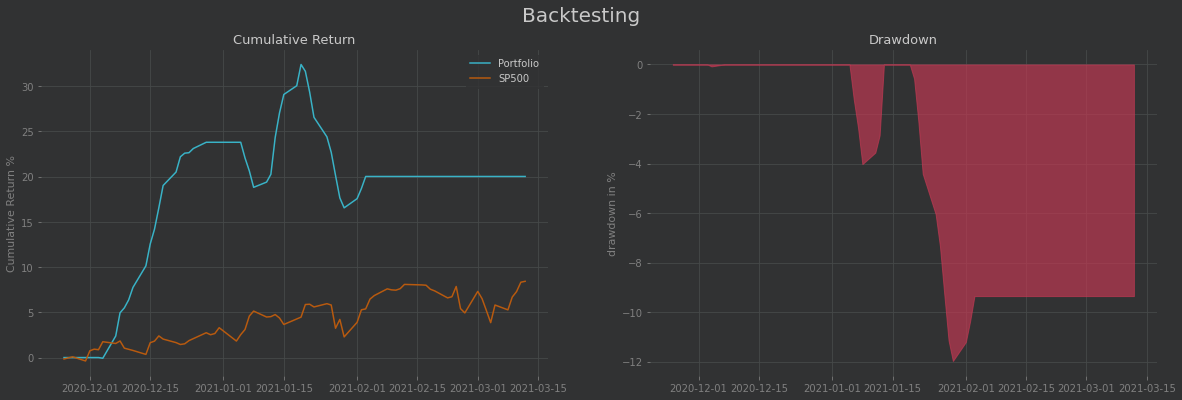

Sortino: 2.345
Beta: 0.077
Alpha: 12.475 %
MaxDrawdown: 11.973 %


In [ ]:
namelist=["BTC", "ETH", "LTC", "ETC", "XMR"]
returns = pd.DataFrame()
for name in namelist:
  ret = RandomForest(f"{name}USD_D1.csv", lag=7)
  returns = pd.concat((returns,ret),axis=1)
  BackTest(ret, 52)